In [63]:
import pickle as pkl
import numpy as np
import os
from typing import Dict
from matplotlib import pyplot as plt
from mrl.util import normalize_diffs

In [19]:
os.chdir('/home/joschnei/multimodal-reward-learning/data/miner/near-original-reward/7/compare/flip-0.07/boltzmann/inference-gt/ars-mixed/sum-length/dedup')
os.getcwd()

'/data/joschnei/multimodal-reward-learning/data/miner/near-original-reward/7/compare/flip-0.07/boltzmann/inference-gt/ars-mixed/sum-length/dedup'

In [23]:
reward_samples = np.load('trials/reward_sample.npy')
likelihoods: Dict[str, np.ndarray] = pkl.load(open('trials/trial-0/likelihood.pkl', 'rb'))
true_reward = np.load('trials/true_reward.npy')
mean_rewards = pkl.load(open('trials/trial-0/mean_reward.pkl', 'rb'))

In [27]:
print(likelihoods.keys())
print(likelihoods['traj'].shape)

dict_keys(['state', 'traj', 'joint'])
(100001, 1000)


In [30]:
max_index = np.argmax(likelihoods['traj'][:,-1])
max_likelihood = likelihoods['traj'][max_index,-1]
map_reward = reward_samples[max_index]

mean_reward = mean_rewards['traj'][-1]
print(f"""True reward={true_reward}
MAP reward={map_reward} with likelihood {max_likelihood}
Mean reward={mean_reward}""")

True reward=[ 0.70359754 -0.70359754 -0.07035975 -0.07035975]
MAP reward=[ 0.61548267 -0.78271119 -0.08113839 -0.04428136] with likelihood 0.09030661444966924
Mean reward=[ 0.21686109 -0.17321098 -0.09117836 -0.04841906]


In [32]:
top_ten_indices = np.argsort(likelihoods['traj'][:,-1])[-10:]
top_ten_likelihoods = likelihoods['traj'][top_ten_indices,-1]
top_ten_rewards = reward_samples[top_ten_indices]
for reward, likelihood in zip(top_ten_rewards, top_ten_likelihoods):
    print(f"reward={reward} with likelihood {likelihood}")

reward=[ 0.64391726 -0.75908423 -0.07358372 -0.06121379] with likelihood 0.03496673165018611
reward=[-0.79544533 -0.59557871 -0.10169814 -0.04701301] with likelihood 0.03650543200316738
reward=[-0.86841978 -0.48415878 -0.09800261 -0.04281174] with likelihood 0.03986493379873648
reward=[-0.16765471 -0.97912173 -0.10630116 -0.04373337] with likelihood 0.04806403087398655
reward=[ 0.17949069 -0.97777312 -0.09342257 -0.05490948] with likelihood 0.05718620045751502
reward=[ 0.89303535 -0.43681393 -0.10037067 -0.04008976] with likelihood 0.061845357210167075
reward=[ 0.96070888  0.25643553 -0.09096554 -0.05481364] with likelihood 0.06474068023126947
reward=[ 0.80693625  0.58083807 -0.09544922 -0.0486875 ] with likelihood 0.07299675254505322
reward=[-0.36820957 -0.92368185 -0.09653187 -0.04376236] with likelihood 0.07596383790614607
reward=[ 0.61548267 -0.78271119 -0.08113839 -0.04428136] with likelihood 0.09030661444966924


So we're not even consistently right on the sign of the first and sceond traj_features. Let's look at our difference vectors.

In [51]:
temps = pkl.load(open('trials/temp.pkl', 'rb'))
traj_features = np.load(f"/home/joschnei/multimodal-reward-learning/data/miner/near-original-reward/7/prefs/traj/{temps['traj']}/dedup/norm-sum-length/prefs.features.npy")
state_features = np.load(f"/home/joschnei/multimodal-reward-learning/data/miner/near-original-reward/7/prefs/state/{temps['state']}/dedup/norm-sum-length/prefs.features.npy")

In [41]:
traj_features.shape

(1, 1000, 2, 4)

In [95]:
def plot_feature_diffs(features: np.ndarray, title: str):
    diffs = normalize_diffs(features, mode='sum-length')
    oriented_diffs = (diffs.T * ((diffs @ true_reward > 0) * 2 - 1)).T
    assert np.all(oriented_diffs @ true_reward >= 0)
    for i in range(oriented_diffs.shape[-1]):
        feature = oriented_diffs[:,i]
        print(f"mean={np.mean(feature)}, std={np.std(feature)}, min={np.min(feature)}, max={np.max(feature)} gt={true_reward[i]}")
        plt.hist(feature)
        plt.title(title)
        plt.show()
        plt.close()

mean=-0.00015248189978599036, std=0.0006016633278814538, min=-0.004008350497357187, max=0.004150549255533489 gt=0.7035975447302919


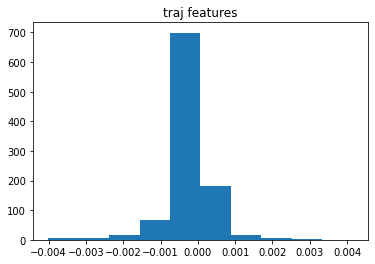

mean=-0.00010604029599673246, std=0.0006537459164806065, min=-0.007575827730908946, max=0.004150549255533489 gt=-0.7035975447302919


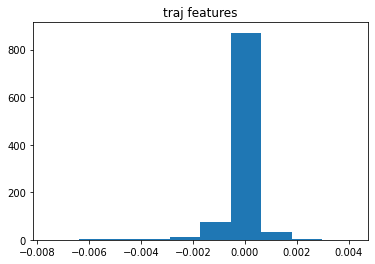

mean=-0.1842542807605874, std=0.15380243953777017, min=-0.8134673758372509, max=0.13818218219240952 gt=-0.0703597544730292


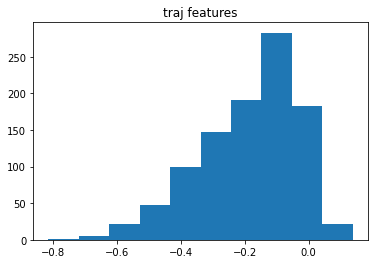

mean=-0.3666662173404505, std=0.24977242518708082, min=-0.9437589927546914, max=0.09693233846818969 gt=-0.0703597544730292


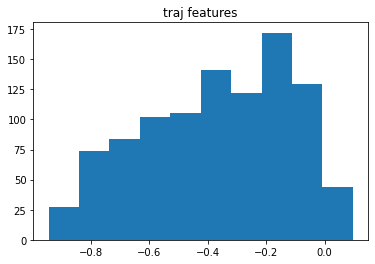

In [97]:
plot_feature_diffs(traj_features[0], 'traj features')

The signal on these first two features is almost nonexistant. The sign on the first feature is wrong, on avegerage. We might be able to get the magnitudes to be larger with a different normalization scheme, but we can't fix the sign.

mean=0.014377189392674433, std=0.025027599563412314, min=-0.06601376202416302, max=0.07073348480207926 gt=0.7035975447302919


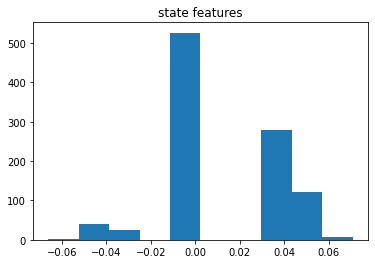

mean=-0.009584160308167024, std=0.02720716263522336, min=-0.06601376202416302, max=0.05115890222105806 gt=-0.7035975447302919


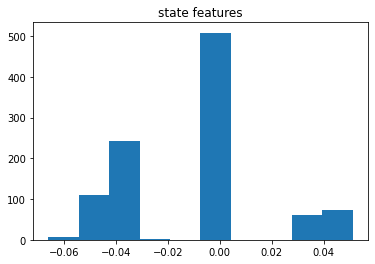

mean=-0.12041303858346057, std=0.25938882542266006, min=-0.6490025325401323, max=0.48889524508696774 gt=-0.0703597544730292


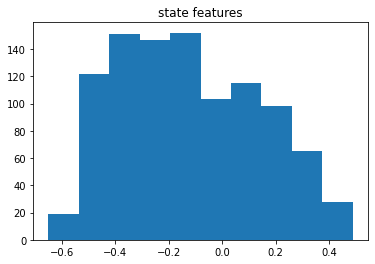

mean=-0.03088435154216885, std=0.15133496166051816, min=-0.48871923368484566, max=0.37060929852474017 gt=-0.0703597544730292


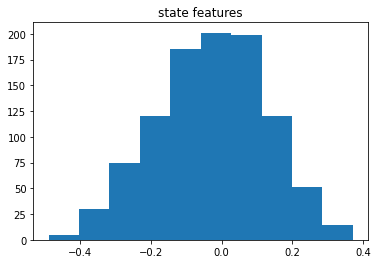

In [98]:
plot_feature_diffs(state_features[0], 'state features')